# Continual Learning Pre - Flight Test Methods : Joint Learning, Sequential Learning

## Necessary Installs

In [1]:
!pip install -q monai einops

## Necessary Imports

In [2]:
# imports and installs
import torch
import torch.nn as nn
import torch.nn.functional as F
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.optim import SGD, Adam, ASGD

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import monai
from monai.transforms import (ScaleIntensityRange, Compose, AddChannel, RandSpatialCrop, ToTensor, 
                            RandAxisFlip, Activations, AsDiscrete, Resize, RandRotate, RandFlip, EnsureType,
                             KeepLargestConnectedComponent)
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, FocalLoss, GeneralizedDiceLoss, DiceCELoss, DiceFocalLoss
from monai.networks.nets import UNet, VNet, UNETR, SwinUNETR, AttentionUnet
from monai.data import decollate_batch, ImageDataset
from monai.utils import set_determinism
import os
import wandb
from time import time
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from random import sample

torch.manual_seed(2000)
set_determinism(seed=2000)

wandb_log = True

## Create Data Loader 

In [3]:
# def get_img_label_folds(img_paths, label_paths):
    
#     fold = list(range(0,len(img_paths)))
#     fold = sample(fold, k=len(fold))
#     fold_imgs = [img_paths[i] for i in fold]
#     fold_labels = [label_paths[i] for i in fold]
#     return fold_imgs, fold_labels


# def get_dataloaders(
#     dataset : str ,
#     batch_size : int ,
#     test_size : float ,
#     roi_size : int ,
#     test_shuffle : bool ,
# ):
#     """_summary_

#     Args:
#         dataset (str): dataset name
#         batch_size (int): batch size
#         test_size (float): test size ratio
#     """
    
#     transforms_map = {
#         "train_img_transform" : [
#             AddChannel(),
#             RandSpatialCrop(roi_size= roi_size, random_center = True, random_size=False),
#             ToTensor()
#             ],
#         "train_label_transform" : [
#             AddChannel(),
#             RandSpatialCrop(roi_size= roi_size, random_center = True, random_size=False),
#             AsDiscrete(threshold=0.5),
#             ToTensor()
#             ],
#         "test_img_transform" : [
#             AddChannel(),
#             ToTensor()
#             ],
#         "test_label_transfrom" : [
#             AddChannel(),
#             AsDiscrete(threshold=0.5),
#             ToTensor()
#             ]
#     }
    
#     dataset_map = {
#         "promise12" : {
#             "data_dir" : "../input/promise12prostatealigned/",
# #             "data_dir" : "../../MIS/datasets/promise12/rot_scale/",
            
#             },
#         # Issue in reading the original pixdim for decathlon prostate dataset.
#         # Fix the pixdim by manually setting it to 1.
#         "decathlon" : {
#             "data_dir" : "../input/decathlonprostatealigned/",
# #             "data_dir" : "../../MIS/datasets/Task05_Prostate/",
#             },
#         "isbi" : {
#             "data_dir" : "../input/isbiprostatealigned/",
# #             "data_dir" : "../../MIS/datasets/ISBI_V2/",
#             }
#     }
    
#     if dataset not in dataset_map:
#         raise ValueError("Dataset {} is not supported".format(dataset))
    
#     # Get image paths and label paths
    
#     dataset_dict = dataset_map[dataset]
#     img_paths = glob(dataset_dict["data_dir"] + "imagesTr/*.nii")
#     label_paths = glob(dataset_dict["data_dir"] + "labelsTr/*.nii")
#     img_paths.sort()
#     label_paths.sort()


#     # Get folds
#     images_fold, labels_fold  = get_img_label_folds(img_paths, label_paths)
# #     images_fold, labels_fold  = img_paths, label_paths
    
#     print("Number of images: {}".format(len(images_fold)))
#     print("Number of labels: {}".format(len(labels_fold)))

#     # Get train and test sets
#     train_idx = int(len(images_fold) * (1 - test_size))
        
#     train_set = ImageDataset(images_fold[:train_idx], labels_fold[:train_idx],
#                             transform=Compose(transforms_map['train_img_transform']), 
#                             seg_transform=Compose(transforms_map['train_label_transform']))

#     test_set = ImageDataset(images_fold[train_idx:], labels_fold[train_idx:],
#                         transform=Compose(transforms_map['test_img_transform']),
#                         seg_transform=Compose(transforms_map['test_label_transfrom']))


#     # Get dataloaders for train and test sets
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=test_shuffle)
    
#     return train_loader, test_loader

In [4]:
def get_img_label_folds(img_paths, label_paths):
    
    fold = list(range(0,len(img_paths)))
    fold = sample(fold, k=len(fold))
    fold_imgs = [img_paths[i] for i in fold]
    fold_labels = [label_paths[i] for i in fold]
    return fold_imgs, fold_labels

# Transforms for images & labels
train_roi_size = 160
transforms_map = {
        "train_img_transform" : [
            AddChannel(),
            RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            ToTensor()
            ],
        "train_label_transform" : [
            AddChannel(),
            RandSpatialCrop(roi_size= train_roi_size, random_center = True, random_size=False),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
        "test_img_transform" : [
            AddChannel(),
            ToTensor()
            ],
        "test_label_transform" : [
            AddChannel(),
            AsDiscrete(threshold=0.5),
            ToTensor()
            ],
    }

# 1. Image & Label paths

dataset_map = {
        "promise12" : {
            "data_dir" : "../input/promise12prostatealigned/",
            "test_size" : 0.1,
            'test' :  {'images' : [], 'labels' : []}
            },
        "decathlon" : {
            "data_dir" : "../input/decathlonprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []}
            },
        "isbi" : {
            "data_dir" : "../input/isbiprostatealigned/",
            "test_size" : 0.2,
            'test' :  {'images' : [], 'labels' : []}
            }
    }

train_fold = {'images' : [], 'labels' : []}

for dataset in dataset_map:
    data_dir = dataset_map[dataset]['data_dir']

    img_paths = glob(data_dir + "imagesTr/*.nii")
    label_paths = glob(data_dir + "labelsTr/*.nii")
    img_paths.sort()
    label_paths.sort()
    
    dataset_map[dataset]['img_paths'] = img_paths
    dataset_map[dataset]['label_paths'] = label_paths
    
    # 2. Folds

    images_fold, labels_fold  = get_img_label_folds(img_paths, label_paths)
    
    dataset_map[dataset]['images_fold'] = images_fold
    dataset_map[dataset]['labels_fold'] = labels_fold
    
    print("Number of images: {}".format(len(images_fold)))
    print("Number of labels: {}".format(len(labels_fold)))
    

    # Get train and test sets
    # 3. Split into train - test
    train_idx = int(len(images_fold) * (1 - dataset_map[dataset]['test_size']))
    
    # 4. Combine train and shuffle
    train_fold['images'] += images_fold[:train_idx]
    train_fold['labels'] += labels_fold[:train_idx]
    
    # Store test sets 
    
    dataset_map[dataset]['test']['images'] = images_fold[train_idx:]
    dataset_map[dataset]['test']['labels'] = labels_fold[train_idx:]
    

    
print(f"\n\nJoint traning samples : {len(train_fold['images'])}")
print(f"Promise12 Test Samples : {len(dataset_map['promise12']['test']['images'])}")
print(f"ISBI Test Samples : {len(dataset_map['isbi']['test']['images'])}")
print(f"Decathlon Test Samples : {len(dataset_map['decathlon']['test']['images'])}")
    

    
# 5. Image dataset
train_set = ImageDataset(train_fold['images'], train_fold['labels'],
                            transform=Compose(transforms_map['train_img_transform']), 
                            seg_transform=Compose(transforms_map['train_label_transform']))

promise12_test = ImageDataset(dataset_map['promise12']['test']['images'], dataset_map['promise12']['test']['labels'],
                            transform=Compose(transforms_map['test_img_transform']), 
                            seg_transform=Compose(transforms_map['test_label_transform']))

isbi_test = ImageDataset(dataset_map['isbi']['test']['images'], dataset_map['isbi']['test']['labels'],
                            transform=Compose(transforms_map['test_img_transform']), 
                            seg_transform=Compose(transforms_map['test_label_transform']))

decathlon_test = ImageDataset(dataset_map['decathlon']['test']['images'], dataset_map['decathlon']['test']['labels'],
                            transform=Compose(transforms_map['test_img_transform']), 
                            seg_transform=Compose(transforms_map['test_label_transform']))
# 6. Get train loader & 3 test loaders
batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
promise12_loader = DataLoader(promise12_test, batch_size=batch_size, shuffle=True)
isbi_loader = DataLoader(isbi_test, batch_size=batch_size, shuffle=True)
decathlon_loader = DataLoader(decathlon_test, batch_size=batch_size, shuffle=True)

# 7. That's it

Number of images: 50
Number of labels: 50
Number of images: 32
Number of labels: 32
Number of images: 79
Number of labels: 79


Joint traning samples : 133
Promise12 Test Samples : 5
ISBI Test Samples : 16
Decathlon Test Samples : 7


## Visualize dataset


Image shape : torch.Size([20, 1, 160, 160])
Label shape : torch.Size([20, 1, 160, 160])


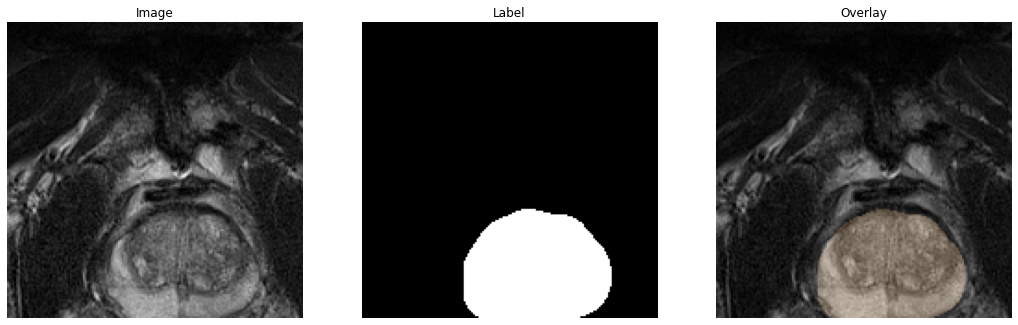

In [5]:
# ----------------------------Get dataloaders--------------------------
imgs,labels = next(iter(train_loader))
imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
labels = rearrange(labels, 'b c h w d -> (b d) c h w')
print(f"\nImage shape : {imgs.shape}")
print(f"Label shape : {labels.shape}")

img_no = 8
plt.figure(figsize=(6*3,6*1))
plt.subplot(1,3,1)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(labels[img_no,0], cmap='gray')
plt.axis('off')
plt.title('Label')
plt.subplot(1,3,3)
plt.imshow(imgs[img_no,0], cmap='gray')
plt.imshow(labels[img_no,0], 'copper', alpha=0.2)
plt.axis('off')
plt.title('Overlay')
plt.show()

### Train - Test Statistics


Training samples : 133


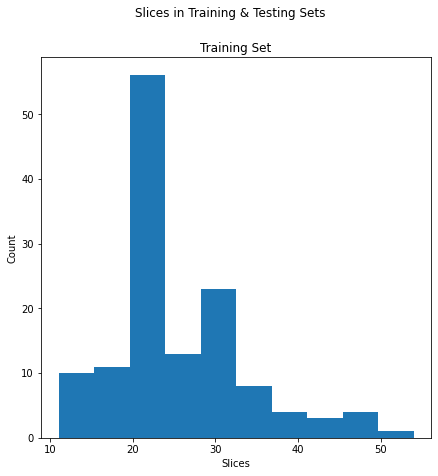

In [6]:
print(f"\nTraining samples : {len(train_loader)}")
# print(f"Testing samples : {len(test_loader)}")

# -----------------------Slices-----------------------------

plt.figure(figsize = (1*7, 1*7))

slices = [label.shape[4] for _, label in train_loader]

# plt.subplot(1,2,1)
plt.hist(slices, )
plt.xlabel('Slices')
plt.ylabel('Count')
plt.title('Training Set')

# slices = [label.shape[4] for _, label in test_loader]
# plt.subplot(1,2,2)
# plt.hist(slices, )
# plt.xlabel('Slices')
# plt.ylabel('Count')
# plt.title('Testing set')

plt.suptitle('Slices in Training & Testing Sets')
plt.show()

## Train Config, Loss, Metrics

In [9]:
# ----------------------------Train Config-----------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

model = UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

epochs = 100
initial_lr = 1e-3
optimizer = Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
# optimizer = ASGD(model.parameters(), lr=initial_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=True)
# scheduler = ExponentialLR(optimizer, gamma=0.98)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
hd_metric = HausdorffDistanceMetric(include_background=False, percentile = 95.)


# post_trans = Compose([ToTensor(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_pred = Compose([
    EnsureType(), AsDiscrete(argmax=True, to_onehot=2),
    KeepLargestConnectedComponent(applied_labels=[1], is_onehot=True, connectivity=2)
])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])
argmax = AsDiscrete(argmax=True)
# dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
# bce_loss = nn.BCEWithLogitsLoss()
# ce_loss = nn.CrossEntropyLoss(weight = torch.tensor([1., 20.], device = device))
# focal_loss = FocalLoss(to_onehot_y = True, weight = [.5, 95.])
dice_ce_loss = DiceCELoss(to_onehot_y=True, softmax=True,)
# dice_focal_loss = DiceFocalLoss(to_onehot_y=True, softmax=True, focal_weight = torch.tensor([1., 5.], device = device))
# focal_weight = torch.tensor([1., 20.], device = device)
# weight = torch.tensor([1., 5.], device = device)

Device: cuda:0
Adjusting learning rate of group 0 to 1.0000e-03.


## WANDB Logging

In [8]:
# ------------------------------------WANDB Logging-------------------------------------
config = {
    "Model" : "UNet2D",
    "Train Input ROI size" : train_roi_size,
#     "Test Input size" : (1, 320, 320),
    "Test mode" : f"Sliding window inference roi = {train_roi_size}",
    "Batch size" : "No of slices in original volume",
    "No of volumes per batch" : 1,
    "Epochs" : epochs,
    "Optimizer" : "Adam",
    "Scheduler" : "CosineAnnealingLR",
    "Initial LR" : scheduler.get_last_lr()[0],
    "Loss" : "DiceCELoss", 
    "Train Data Augumentations" : "RandSpatialCrop",
    "Test Data Preprocess" : "None",
    "Train samples" : len(train_loader),
    "Test Samples" : {"Promise12" : 5, "ISBI" : 16, "Decathlon" : 7},
#     RandFlip, RandRotate90, RandGaussianNoise, RandGaussSmooth, RandBiasField, RandContrast
    "Pred Post Processing" : "KeepLargestConnectedComponent"
}
if wandb_log:
    wandb.login()
    wandb.init(project="CL_Joint", entity="vinayu", config = config)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vinayu. Use `wandb login --relogin` to force relogin


## Joint Traning

## Training function 

In [10]:
def train():
    """
    Inputs : No Inputs
    Outputs : No Outputs
    Function : Trains all datasets and logs metrics to WANDB
    """
    
    train_start = time()
    epoch_loss = 0
    model.train()
    print('\n')
    
    
    # Iterating over the dataset
    for i, (imgs, labels) in enumerate(train_loader, 1):

        imgs = imgs.to(device)
        labels = labels.to(device)
        imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
        labels = rearrange(labels, 'b c h w d -> (b d) c h w')

        optimizer.zero_grad()
        preds = model(imgs)

        loss = dice_ce_loss(preds, labels)

        preds = [post_pred(i) for i in decollate_batch(preds)]
        preds = torch.stack(preds)
        labels = [post_label(i) for i in decollate_batch(labels)]
        labels = torch.stack(labels)
    #         Metric scores
        dice_metric(preds, labels)
        hd_metric(preds, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % batch_interval == 0:
            print(f"Epoch: [{epoch}/{epochs}], Batch: [{i}/{len(train_loader)}], Loss: {loss.item() :.4f}, \
                  Dice: {dice_metric.aggregate().item() * 100 :.2f}, HD: {hd_metric.aggregate().item() :.2f}")
    
    # Print metrics, log data, reset metrics
    
    print(f"\nEpoch: [{epoch}/{epochs}], Avg Loss: {epoch_loss / len(train_loader) :.3f}, \
              Train Dice: {dice_metric.aggregate().item() * 100 :.2f}, Train HD: {hd_metric.aggregate().item() :.2f}, Time : {int(time() - train_start)} sec")

    if wandb_log:
        wandb.log({"Train Dice" : dice_metric.aggregate().item() * 100,
                   "Train Hausdorff Distance" : hd_metric.aggregate().item(),
                   "Train Loss" : epoch_loss / len(train_loader),
                   "Learning Rate" : scheduler.get_last_lr()[0],
                   "Epoch" : epoch })

    dice_metric.reset()
    hd_metric.reset()
    scheduler.step()


## Validation function

In [11]:
batch_size = 1
test_shuffle = True

dataloaders_map = {
    'promise12' : promise12_loader,
    'isbi' : isbi_loader,
    'decathlon' : decathlon_loader,
}

test_map_config = {
            'promise12' : {'roi_size' : 160},
            'isbi' : {'roi_size' : 160},
            'decathlon' : {'roi_size' : 160},
           }


metrics_map = {}
for dname in dataloaders_map:
    metrics_map[dname] = {
        f'{dname}_curr_dice' : 0,
        f'{dname}_best_dice' : 0,
        f'{dname}_curr_hd' : 1e10,
        f'{dname}_best_hd' : 1e10,
        'Epoch' : 0
    }


In [12]:
def validate(test_loader : DataLoader, dataset_name : str):
    """
    Inputs : Testing dataloader
    Outputs : Returns Dice, HD
    Function : Validate on the given dataloader and return the mertics 
    """
    train_start = time()
    model.eval()
    with torch.no_grad():
        # Iterate over all samples in the dataset
        for i, (imgs, labels) in enumerate(test_loader, 1):
            imgs = imgs.to(device)
            labels = labels.to(device)
            imgs = rearrange(imgs, 'b c h w d -> (b d) c h w')
            labels = rearrange(labels, 'b c h w d -> (b d) c h w')

            roi_size = (test_map_config[dataset_name]['roi_size'], test_map_config[dataset_name]['roi_size'])
            preds = sliding_window_inference(inputs=imgs, roi_size=roi_size, sw_batch_size=4,
                                            predictor=model, overlap = 0.5, mode = 'gaussian', device=device)
#                 preds = model(imgs)
            preds = [post_pred(i) for i in decollate_batch(preds)]
            preds = torch.stack(preds)
            labels = [post_label(i) for i in decollate_batch(labels)]
            labels = torch.stack(labels)

            dice_metric(preds, labels)
            hd_metric(preds, labels)

        val_dice = dice_metric.aggregate().item()
        val_hd = hd_metric.aggregate().item()
        
        dice_metric.reset()
        hd_metric.reset()
        
        print("-"*75)
        print(f"Epoch : [{epoch}/{epochs}], Dataset : {dataset_name.upper()}, Test Avg Dice : {val_dice*100 :.2f}, Test Avg HD : {val_hd :.2f}, Time : {int(time() - train_start)} sec")
        print("-"*75)
        
        return val_dice, val_hd

## Training & Validation 

In [13]:
# The main training & validation loop

print("Training started ... \n")

val_interval = 1
batch_interval = 30

for epoch in range(1, epochs+1):
    # Trains on all datasets
    train()
    
    # Validation on each dataset individually and log metrics
    for dataset_name in dataloaders_map:
#         print(f'-----------Validating on {dataset_name.upper()}-----------')
        test_loader = dataloaders_map[dataset_name]
        
        val_dice, val_hd = validate(test_loader, dataset_name)
        val_dice *= 100
        
        metrics = metrics_map[dataset_name]
        
        metrics[f'Epoch'] = epoch
        metrics[f'{dataset_name}_curr_dice'] = val_dice 
        metrics[f'{dataset_name}_curr_hd'] = val_hd
        
        
        
        if val_dice > metrics[f'{dataset_name}_best_dice']:

            metrics[f'{dataset_name}_best_dice'] = val_dice 
#             best_dice_epoch = epoch
#             torch.save(model.state_dict(), "best_model.pt")
#             print(f"Best model saved at epoch {best_metric_epoch} with Dice {best_metric*100:.2f}")


        if val_hd < metrics[f'{dataset_name}_best_hd'] and val_hd > 0:

            metrics[f'{dataset_name}_best_hd'] = val_hd
#             best_hd_epoch = epoch

        if wandb_log:
            # Quantiative metrics
            wandb.log(metrics)

            # Qualitative resulsts
            
#             preds = torch.stack([argmax(c) for c in preds])
#             labels = torch.stack([argmax(c) for c in labels])

#             f = make_grid(torch.cat([imgs,labels,preds],dim=3), nrow =2, padding = 20, pad_value = 1)
#             images = wandb.Image(rearrange(f.cpu(), 'c h w -> h w c'), caption="Left: Input, Middle : Ground Truth, Right: Prediction")
#             wandb.log({"Predictions": images, "Epoch" : epoch})
            
    print('Logged data to wandb')

Training started ... 





/opt/conda/lib/python3.7/site-packages/monai/metrics/hausdorff_distance.py:168: UserWarning: the ground truth of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the ground truth of class {c} is all 0, this may result in nan/inf distance.")
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Epoch: [1/100], Batch: [30/133], Loss: 1.2004,                   Dice: 28.31, HD: 90.84
Epoch: [1/100], Batch: [60/133], Loss: 0.9438,                   Dice: 31.95, HD: 76.95
Epoch: [1/100], Batch: [90/133], Loss: 0.9091,                   Dice: 31.00, HD: 73.71


/opt/conda/lib/python3.7/site-packages/monai/metrics/hausdorff_distance.py:170: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


Epoch: [1/100], Batch: [120/133], Loss: 0.7775,                   Dice: 26.37, HD: 74.22

Epoch: [1/100], Avg Loss: 0.996,               Train Dice: 25.54, Train HD: 73.50, Time : 37 sec
Adjusting learning rate of group 0 to 9.9975e-04.
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : PROMISE12, Test Avg Dice : 23.51, Test Avg HD : 104.94, Time : 7 sec
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : ISBI, Test Avg Dice : 32.20, Test Avg HD : 86.51, Time : 20 sec
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Epoch : [1/100], Dataset : DECATHLON, Test Avg Dice : 28.73, Test Avg HD : 87.69, Time : 4 sec
---------------------------------------------------------------------------
Logged data to wandb


Ep